In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

In [ ]:
DATA_PATH = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'

import re
list_for_df = []
for traindata in os.listdir(os.path.join(DATA_PATH, 'train/train')):
#   print(traindata)
  tmplist = []
  if traindata[0] == 'c':
    tmplist.append(0)
  else:
    tmplist.append(1)
  tmplist.append(traindata)
  list_for_df.append(tmplist)

train_df = pd.DataFrame(data=list_for_df, columns=['class','fname'])
train_df['class'] = train_df['class'].astype('str')
train_df.head()
train_df.shape

In [ ]:
train_df.head()

In [ ]:
list_for_df = []
for testdata in os.listdir(os.path.join(DATA_PATH, 'test/test')):
#   print(traindata)
  tmplist = []
  tmplist.append(testdata)
  list_for_df.append(tmplist)

df_test = pd.DataFrame(data=list_for_df, columns=['fname'])

In [28]:
df_test.head()

,fname
0,2562.jpg
1,11848.jpg
2,2864.jpg
3,1441.jpg
4,11107.jpg


In [ ]:
df_test.shape

# Load Data

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(train_df)

In [29]:
df_train.head()

,class,fname
23836,0,cat.664.jpg
20328,0,cat.4067.jpg
2388,1,dog.1294.jpg
19199,0,cat.4873.jpg
1834,1,dog.5264.jpg


In [30]:
df_val.head()

,class,fname
16068,1,dog.9308.jpg
15774,0,cat.2011.jpg
1070,1,dog.696.jpg
21990,0,cat.8387.jpg
1749,1,dog.7948.jpg


In [ ]:
original_dataset_dir = os.path.join(DATA_PATH, 'train/train')

import PIL
from PIL import ImageDraw

tmp_imgs = df_train['fname'][100:110]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
  img = PIL.Image.open(os.path.join(original_dataset_dir, f_name))
  plt.subplot(5,2,num+1)
  plt.title(f_name)
  plt.imshow(img)
  plt.axis('off')

# Xception with fine tuning + data_gen

In [ ]:
from keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))

conv_base.summary()

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name.split('_')[0] == 'block1':
    set_trainable = True
  if layer.name.split('_')[0] == 'block2':
    set_trainable = True
  if layer.name.split('_')[0] == 'block13':
    set_trainable = True
  if layer.name.split('_')[0] == 'block14':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [31]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

img_size = (224,224)
nb_train_samples = len(df_train)
nb_validation_samples = len(df_val)
nb_test_samples = len(df_test)
epochs = 12
batch_size = 64

# Define Generator config
train_datagen = ImageDataGenerator(
  horizontal_flip = True,
  vertical_flip = False,
  zoom_range = 0.10,
  rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

original_dataset_dir = os.path.join(DATA_PATH, 'train/train')

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = original_dataset_dir,
    x_col = 'fname',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    seed = 42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory = original_dataset_dir,
    x_col = 'fname',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False
)

test_data_path = os.path.join(DATA_PATH, 'test/test')

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = test_data_path,
    x_col = 'fname',
    y_col = None,
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = None,
    batch_size = batch_size,
    shuffle = False
)

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [ ]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
  return f1_score(y_true, y_pred, average='micro')

def get_step(num_samples, batch_size):
  if (num_samples % batch_size) > 0:
    return (num_samples // batch_size) + 1
  else:
    return num_samples // batch_size

import keras

class LossHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.val_losses = []
    self.acces = []
    self.val_acces = []


  def on_batch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acces.append(logs.get('acc'))
    self.val_acces.append(logs.get('val_acc'))

loss_history = LossHistory()

In [ ]:
def freeze(model):
    """Freeze model weights in every layer."""
    for layer in model.layers:
        layer.trainable = False

        if isinstance(layer, models.Model):
            freeze(layer)

In [ ]:
model.summary()

In [32]:
from keras import models
from keras import layers
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "Xception.h5"

es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')
callbackList = [es, loss_history]


model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2))
model.add(layers.Activation('softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])

history = model.fit_generator(train_generator,
                   steps_per_epoch=100,
                   epochs=50,
                   validation_data=validation_generator,
                   validation_steps=100,
                   callbacks=callbackList)

# freeze 해줘야함
from keras import models

def freeze(model):
    """Freeze model weights in every layer."""
    for layer in model.layers:
        layer.trainable = False

        if isinstance(layer, models.Model):
            freeze(layer)

freeze(model)
model.save(filepath)

Epoch 1/50
100/100 [==============================] - 202s 2s/step - loss: 0.0978 - acc: 0.9647 - val_loss: 0.0320 - val_acc: 0.9903
Epoch 2/50
100/100 [==============================] - 154s 2s/step - loss: 0.0450 - acc: 0.9838 - val_loss: 0.0287 - val_acc: 0.9901
Epoch 3/50
100/100 [==============================] - 152s 2s/step - loss: 0.0367 - acc: 0.9869 - val_loss: 0.0406 - val_acc: 0.9901
Epoch 4/50
100/100 [==============================] - 141s 1s/step - loss: 0.0185 - acc: 0.9930 - val_loss: 0.0623 - val_acc: 0.9853
Epoch 5/50
100/100 [==============================] - 141s 1s/step - loss: 0.0188 - acc: 0.9931 - val_loss: 0.0261 - val_acc: 0.9922
Epoch 6/50
100/100 [==============================] - 142s 1s/step - loss: 0.0177 - acc: 0.9937 - val_loss: 0.0380 - val_acc: 0.9901
Epoch 7/50
100/100 [==============================] - 143s 1s/step - loss: 0.0095 - acc: 0.9970 - val_loss: 0.0290 - val_acc: 0.9931
Epoch 8/50
100/100 [==============================] - 143s 1s/step - 

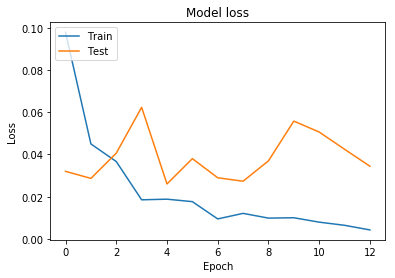

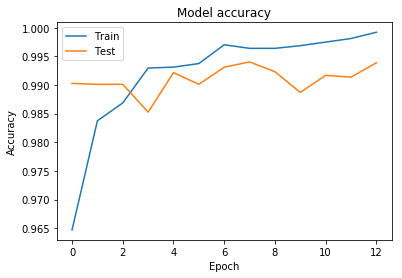

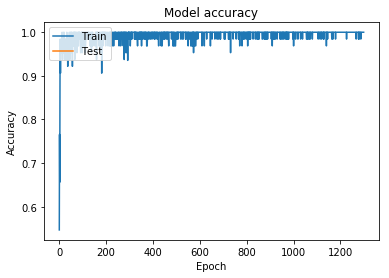

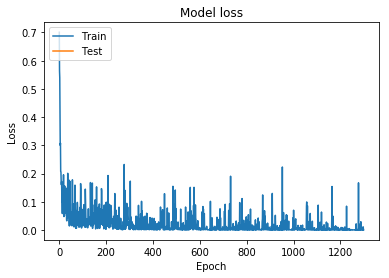

In [33]:
import matplotlib.pyplot as plt

history = model.history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(loss_history.acces)
plt.plot(loss_history.val_acces)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(loss_history.losses)
plt.plot(loss_history.val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# get answer

In [35]:
steps = len(df_test) // batch_size + 1

In [36]:
mypred = model.predict_generator(
    test_generator,
    steps=steps
)

In [43]:
mypred_val = np.argmax(mypred, axis=1)
mypred_val.shape

(12500,)

# check_by_eye

In [48]:
df_test.head()

,fname
0,2562.jpg
1,11848.jpg
2,2864.jpg
3,1441.jpg
4,11107.jpg


In [64]:
id_val = df_test['fname'].str.split(".").str[0].values
id_val

array(['2562', '11848', '2864', ..., '8921', '1191', '6780'], dtype=object)

In [66]:
np.shape(id_val)

(12500,)

In [52]:
sptl = df_test['fname'][:30].values

In [53]:
sptl

array(['2562.jpg', '11848.jpg', '2864.jpg', '1441.jpg', '11107.jpg',
       '7320.jpg', '8756.jpg', '9239.jpg', '6797.jpg', '10435.jpg',
       '6148.jpg', '2051.jpg', '10711.jpg', '4990.jpg', '5880.jpg',
       '10597.jpg', '1111.jpg', '5563.jpg', '4734.jpg', '6199.jpg',
       '8874.jpg', '2184.jpg', '1436.jpg', '10542.jpg', '7439.jpg',
       '2546.jpg', '6183.jpg', '2166.jpg', '6356.jpg', '9463.jpg'],
      dtype=object)

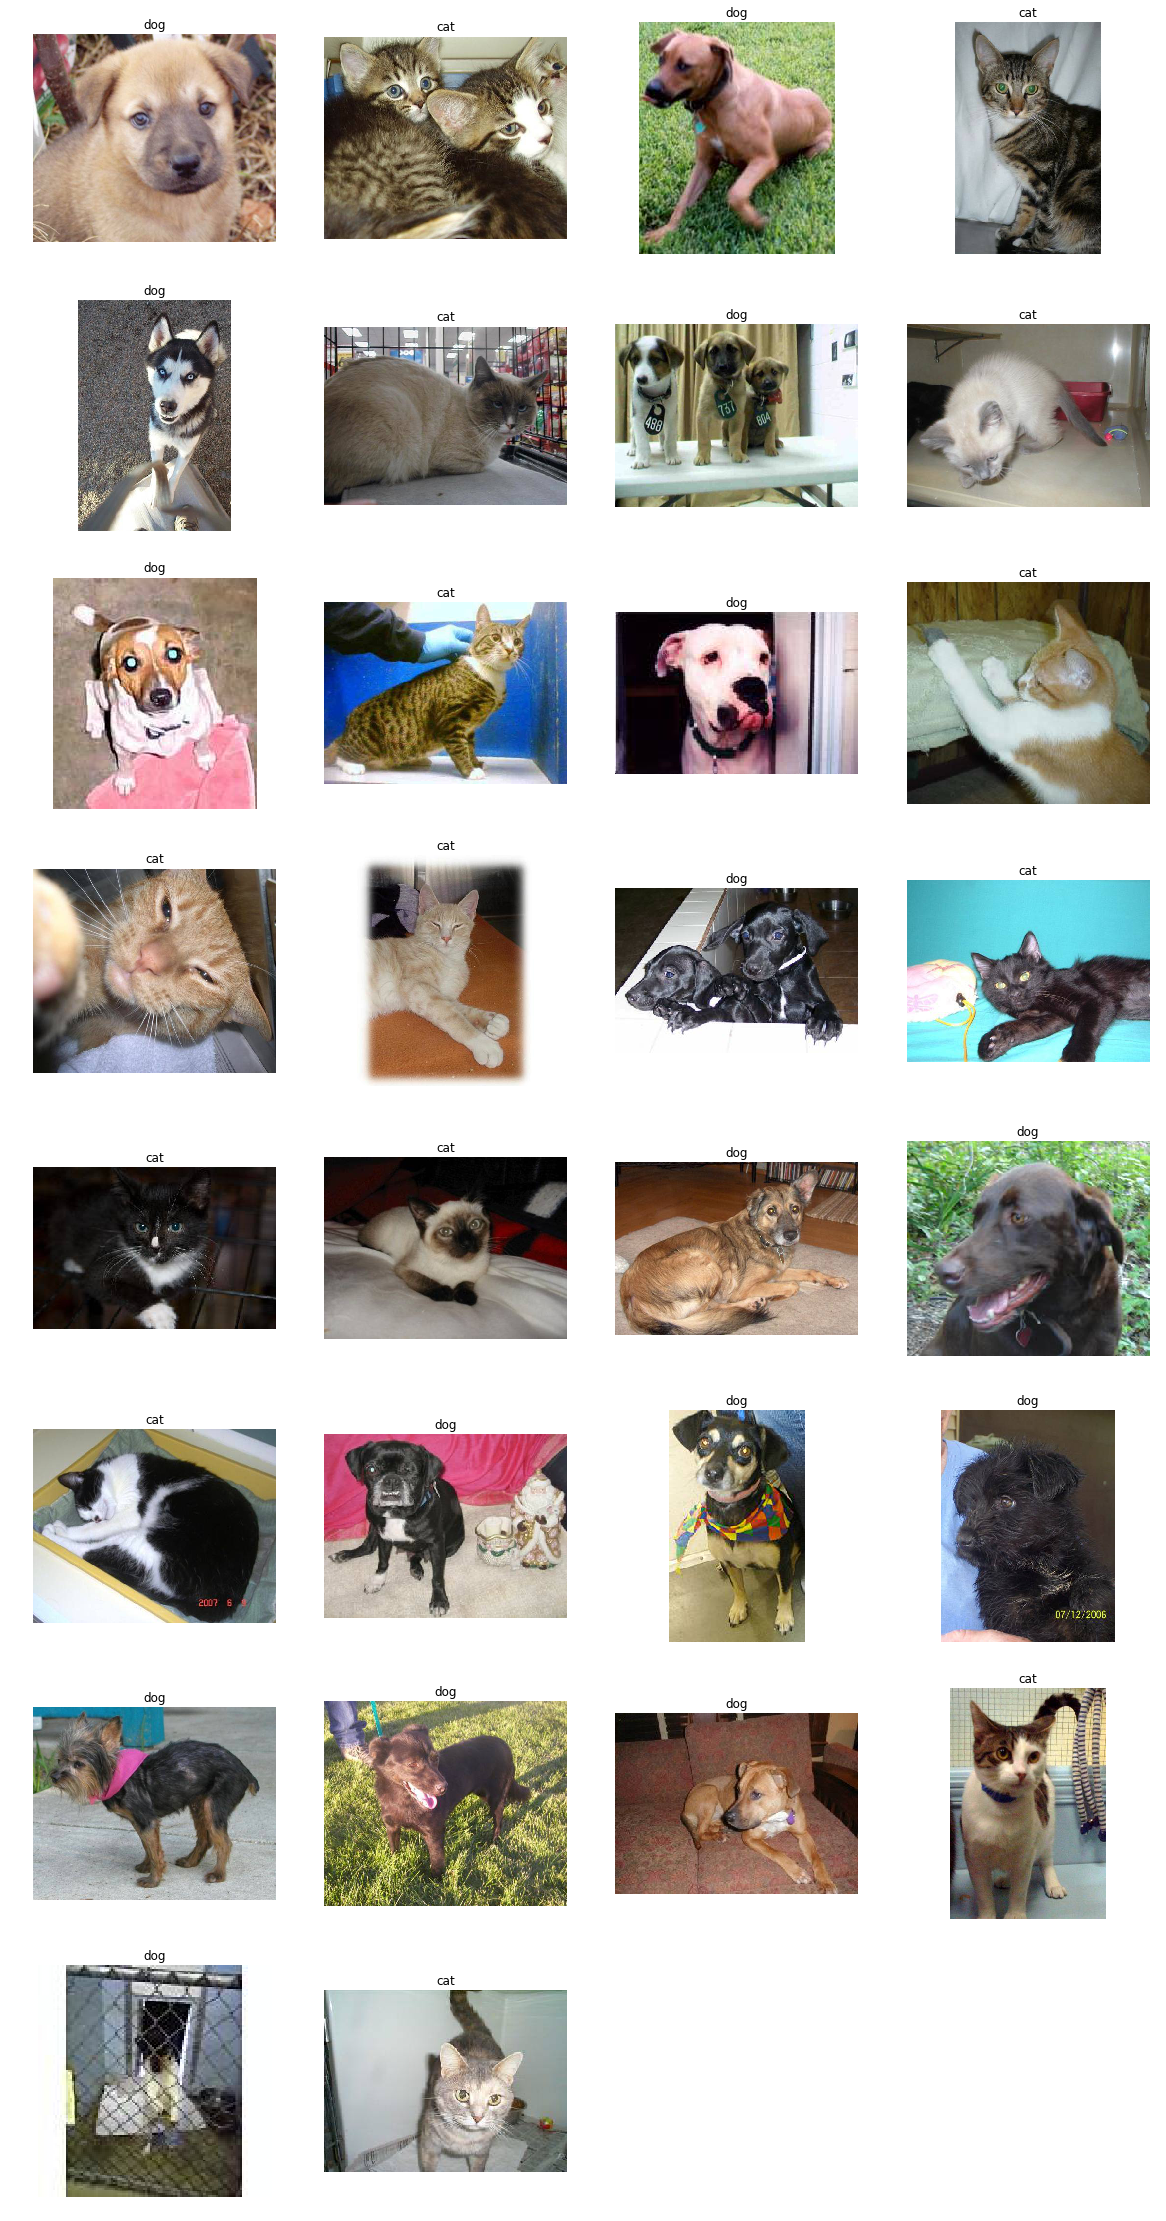

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,40))

testdir = os.path.join(DATA_PATH, 'test/test')

import PIL

num = 0

for fname in sptl:
  img = PIL.Image.open(os.path.join(testdir, fname))
  plt.subplot(8,4,num+1)
  if mypred_val[num]==0:
    plt.title('cat')
  else:
    plt.title('dog')
  plt.axis('off')
  plt.imshow(img)
  num += 1

# submit!

In [55]:
submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))

In [68]:
submission['id'] = id_val
submission['label'] = mypred_val

In [70]:
submission.head()

,id,label
0,2562,1
1,11848,0
2,2864,1
3,1441,0
4,11107,1


In [73]:
my_submission = submission.set_index('id')

In [75]:
my_submission.head()

,label
id,
2562,1
11848,0
2864,1
1441,0
11107,1


In [ ]:
my_submission.to_csv("Xception_submit.csv")